# DeepFi

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

from csidataset import *
import data_loader
from data_loader import *
sys.path.append("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool")
import denoise

In [2]:
base_path = "/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/csi_tool/csi_dataset/localization_phone/1223_phone/5G/20MHz/csv/all"

In [3]:
reference_points = {}

spacing = 0.6  # 每隔 0.6m

for ref_id, coord in data_loader.COORDINATES.items():
    folder_path = os.path.join(base_path, f"reference_point_{ref_id}.xlsx")
    reference_points[folder_path] = (ref_id, coord)

In [4]:
data, rp_labels, coord_labels = load_data(reference_points)
amp_data = np.array(data.iloc[:, :48])  
phase_data = np.array(data.iloc[:, 48:-2]) 

In [5]:
amp_d = denoise.preprocess_csi_for_fingerprint2(amp_data)

In [6]:
encoder = OneHotEncoder(sparse_output=False)
one_hot_labels = encoder.fit_transform(np.array(rp_labels).reshape(-1, 1))

In [7]:
amp_train, amp_temp, y_train, y_temp = train_test_split(amp_data, one_hot_labels, test_size=0.3, random_state=42)
amp_val, amp_test, y_val, y_test = train_test_split(amp_temp, y_temp, test_size=1/3, random_state=42)

In [8]:
# 創建 Dataset 和 DataLoader

batch_size = 32

train_dataset = CSIDataset(amp_train, y_train)
val_dataset = CSIDataset(amp_val, y_val)
test_dataset = CSIDataset(amp_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class DeepFi48(nn.Module):
    def __init__(self, num_classes):
        super(DeepFi48, self).__init__()
        self.fc1 = nn.Linear(48, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.out = nn.Linear(16, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.sigmoid(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        x = self.out(x)
        return x


model = DeepFi48(num_classes=49).to(device)

# Print model summary
summary(model, input_size=(1, 48))  # Input shape: (channels, length)


Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           6,272
           Sigmoid-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 64]           8,256
           Sigmoid-4                [-1, 1, 64]               0
            Linear-5                [-1, 1, 32]           2,080
           Sigmoid-6                [-1, 1, 32]               0
            Linear-7                [-1, 1, 16]             528
           Sigmoid-8                [-1, 1, 16]               0
            Linear-9                [-1, 1, 49]             833
Total params: 17,969
Trainable params: 17,969
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.07
Estimated Total Size (MB): 0.07
--------------------------

In [10]:
import torch.nn as nn
import torch.optim as optim

# 損失函數
criterion = nn.CrossEntropyLoss()

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 學習率調整器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=15, verbose=True)

/home/mcs/anaconda3/envs/kyle_ai/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
import torch
import matplotlib.pyplot as plt
import time

# 儲存最佳模型
best_val_loss = float('inf')
best_model_path = "./models_save/DeepFi.pth"

# 準確率
target_acc = 99.0
best_epoch = None
# 訓練參數
epochs = 200

# early stop
patience = 20
counter = 0  

# 訓練過程中的 loss 和 accuracy
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    start_time = time.perf_counter()  # 記錄開始時間
    # ---- 訓練階段 ----
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        # CrossEntropyLoss 需要 class index
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        train_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    train_acc = 100 * train_correct / total_train

    # ----驗證階段----
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            val_correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    val_acc = 100 * val_correct / total_val
    epoch_time = time.perf_counter() - start_time

    # 紀錄每個 epoch 的 loss 和 accuracy
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


    # 輸出當前 epoch 的結果
    print(f"Epoch [{epoch+1}/{epochs}] | "
          f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%")

    # ---- 儲存最佳模型 ----
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"✅ 儲存最佳模型 (Val Loss: {best_val_loss:.4f}) 至 {best_model_path}")
        counter = 0
    else:
        counter += 1

    # if counter >= patience:
    #     print(f"Early stop at epoch {epoch+1}")
    #     break
    if val_acc >= target_acc and best_epoch is None:
        best_epoch = epoch + 1
    if best_epoch:
        print(f"🎯 達到 {target_acc}% 準確率的 Epoch: {best_epoch}")

print("訓練完成！")


Epoch [1/200] | Train Loss: 3.8993 | Train Acc: 2.15% | Val Loss: 3.8932 | Val Acc: 1.65%
✅ 儲存最佳模型 (Val Loss: 3.8932) 至 ./models_save/DeepFi.pth
Epoch [2/200] | Train Loss: 3.8167 | Train Acc: 3.23% | Val Loss: 3.6188 | Val Acc: 4.55%
✅ 儲存最佳模型 (Val Loss: 3.6188) 至 ./models_save/DeepFi.pth
Epoch [3/200] | Train Loss: 3.4510 | Train Acc: 5.37% | Val Loss: 3.2954 | Val Acc: 6.29%
✅ 儲存最佳模型 (Val Loss: 3.2954) 至 ./models_save/DeepFi.pth
Epoch [4/200] | Train Loss: 3.2552 | Train Acc: 6.01% | Val Loss: 3.2300 | Val Acc: 5.57%
✅ 儲存最佳模型 (Val Loss: 3.2300) 至 ./models_save/DeepFi.pth
Epoch [5/200] | Train Loss: 3.1428 | Train Acc: 7.85% | Val Loss: 3.0569 | Val Acc: 8.37%
✅ 儲存最佳模型 (Val Loss: 3.0569) 至 ./models_save/DeepFi.pth
Epoch [6/200] | Train Loss: 3.0688 | Train Acc: 8.34% | Val Loss: 2.9859 | Val Acc: 7.82%
✅ 儲存最佳模型 (Val Loss: 2.9859) 至 ./models_save/DeepFi.pth
Epoch [7/200] | Train Loss: 2.9511 | Train Acc: 10.48% | Val Loss: 2.9021 | Val Acc: 12.02%
✅ 儲存最佳模型 (Val Loss: 2.9021) 至 ./models

KeyboardInterrupt: 

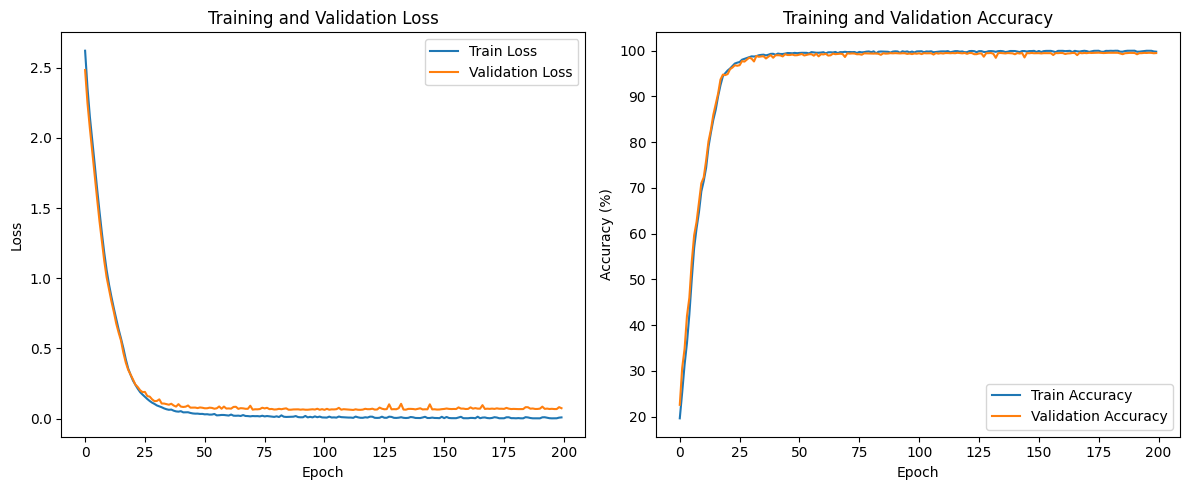

In [41]:
plt.figure(figsize=(12, 5))

# ---- loss ----
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# ---- accuracy ----
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [42]:
# 載入最佳模型
model.load_state_dict(torch.load("/media/mcs/1441ae67-d7cd-43e6-b028-169f78661a2f/kyle/compare_model/models_save/DeepFi.pth"))
model.eval()

# 測試模型
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        test_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

test_loss /= len(test_loader.dataset)
accuracy = 100 * correct / total

print(f"📊 測試損失: {test_loss:.4f}, 測試準確率: {accuracy:.2f}%")

📊 測試損失: 0.0373, 測試準確率: 99.59%
